# Split into Train/Valid/Test set 

## Load Dataset from sklearn

In [97]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

In [98]:
from sklearn.datasets import fetch_california_housing 
california = fetch_california_housing()

In [99]:
df = pd.DataFrame(california.data, columns = california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## Convert to PyTorch Tensor 

In [100]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [101]:
data = torch.from_numpy(df.values).float()

X = data[:,:-1]
y = data[:,-1:]

print(X.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [102]:
# Train / Valid / Test ratio
ratios = [0.6, 0.2, 0.2]

In [103]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train %d / Valid %d / Test %d samples' %(train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples


In [104]:
# shuffle before split 
indices = torch.randperm(data.size(0))
X = torch.index_select(X, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

# Split train, valid and test set with each count.
X = list(X.split(cnts, dim = 0))
y = y.split(cnts, dim = 0)

for X_i, y_i in zip(X, y) : 
    print(X_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


## Preprocessing 

In [105]:
scaler = StandardScaler()

# valid, test set에 대해서는 학습을 하지 않아야 하기 때문에 train set에 대해서만 scaling 
scaler.fit(X[0].numpy())

X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

df = pd.DataFrame(X[0].numpy(), columns = california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,-0.063728,-0.930426,0.147138,-0.131306,-0.273763,-0.061487,1.416402,-0.883447
12380,2.990615,-0.692167,1.370347,-0.317471,1.261599,0.007128,-0.635033,0.498021
12381,-1.139916,1.134491,-0.268242,0.118979,0.131491,0.017511,-0.752393,0.627690
12382,-0.671046,1.849270,-0.732182,-0.135408,0.148991,-0.070565,1.003298,-1.447009
12383,0.278080,-0.533327,-0.021358,-0.140583,1.648433,-0.012296,0.885939,-1.192658


## Build Model & Optimizer 

In [106]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [107]:
optimizer = optim.Adam(model.parameters())

## Train 

In [108]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [109]:
from copy import deepcopy 

lowest_loss = np.inf 
best_model = None 

early_stop = 100
lowest_epoch = np.inf

In [110]:
train_history, valid_history = [], []

# 한 Epoch 안에는 train iteration, valid iteration 크게 2가지가 반복
for i in range(n_epochs) : 
    indices = torch.randperm(X[0].size(0)) # for shuffling 
    X_ = torch.index_select(X[0], dim = 0, index = indices)
    y_ = torch.index_select(y[0], dim = 0, index = indices)
    # |X_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    X_ = X_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0) 
    # |X_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0 
    y_hat = [] # batch size만큼 입력
    
    for X_i, y_i in zip(X_, y_) :  # 12384/256번 반복
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad() # gradient 초기화 필수
        loss.backward() # backpropagation
        
        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)
    
    # valid에서는 gradient descent 하지 X (학습용이 아니기 때문)
    # PyTorch가 computation graph를 build하지 않도록 해야함 
    with torch.no_grad() : 
        # validation set은 shuffle 필요없음
        # Split만 하면 됨 
        X_ = X[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0)
        
        valid_loss = 0
        
        for X_i, y_i in zip(X_, y_) : 
            y_hat_i = model(X_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss 
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(X_) # len(X_) : 미니배치 수 
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if ( i + 1 ) % print_interval == 0 : 
        print('Epoch %d : train loss = %.4e valid loss = %.4e lowest loss = %.4e' % (
        i + 1,
        train_loss,
        valid_loss,
        lowest_loss))
        
    if valid_loss <= lowest_loss : 
        lowest_loss = valid_loss 
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value
        # Take a deep copy, if the valid is lowest ever.
        
        best_model = deepcopy(model.state_dict())
        
    else : 
        if early_stop > 0 and lowest_epoch + early_stop < i + 1 : 
            print('There is no improvement during last %d epochs.' % early_stop)
            break

print('The best validation loss from epoch %d : %4e' % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model
model.load_state_dict(best_model)

Epoch 100 : train loss = 3.6870e-01 valid loss = 3.7469e-01 lowest loss = 3.7540e-01
Epoch 200 : train loss = 3.5089e-01 valid loss = 3.6128e-01 lowest loss = 3.6077e-01
Epoch 300 : train loss = 3.4260e-01 valid loss = 3.5174e-01 lowest loss = 3.4575e-01
Epoch 400 : train loss = 3.3300e-01 valid loss = 3.3948e-01 lowest loss = 3.3904e-01
Epoch 500 : train loss = 3.2287e-01 valid loss = 3.3696e-01 lowest loss = 3.3316e-01
Epoch 600 : train loss = 3.1210e-01 valid loss = 3.2993e-01 lowest loss = 3.2728e-01
Epoch 700 : train loss = 3.0644e-01 valid loss = 3.2298e-01 lowest loss = 3.2199e-01
Epoch 800 : train loss = 3.0600e-01 valid loss = 3.2292e-01 lowest loss = 3.1747e-01
Epoch 900 : train loss = 3.0176e-01 valid loss = 3.1726e-01 lowest loss = 3.1494e-01
Epoch 1000 : train loss = 3.0331e-01 valid loss = 3.1664e-01 lowest loss = 3.1354e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 929 : 3.135360e-01


<All keys matched successfully>

## Loss History

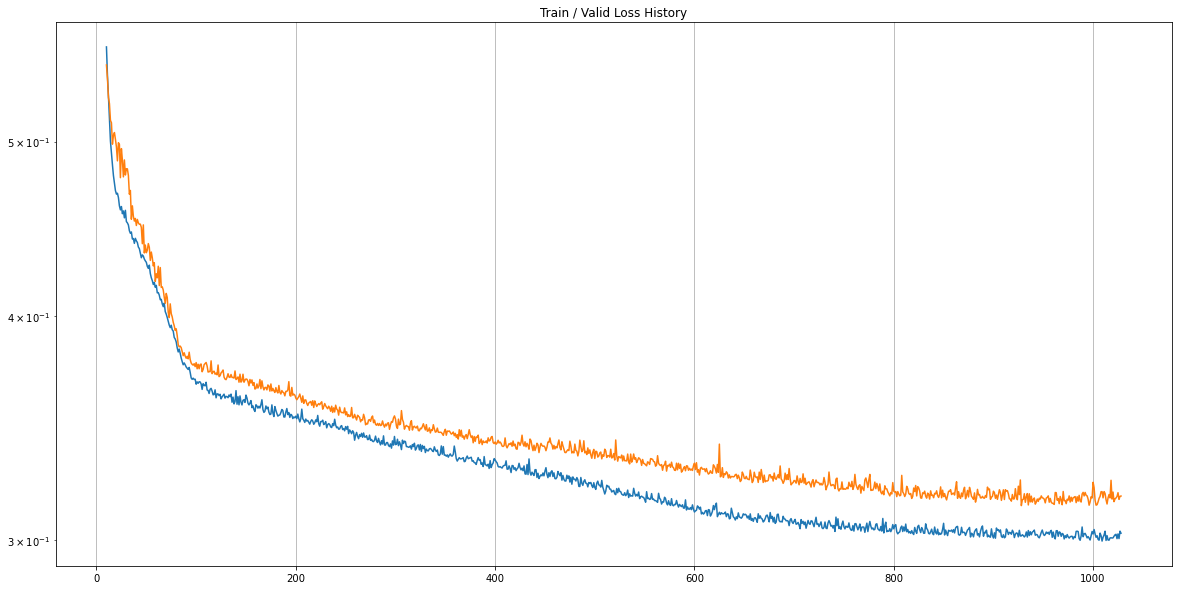

In [111]:
plot_from = 10

plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [113]:
## Result 
test_loss = 0
y_hat = []

with torch.no_grad() : 
    X_ = X[2].split(batch_size, dim = 0)
    y_ = y[2].split(batch_size, dim = 0)    
    
    for X_i, y_i in zip(X_, y_) : 
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += loss
        
        y_hat += [y_hat_i]
        
test_loss = test_loss/len(X_)
y_hat = torch.cat(y_hat, dim = 0)

sorted_history = sorted(zip(train_history, valid_history),
                       key = lambda X : X[1])

print('Train loss : %.4e' % sorted_history[0][0])
print('Valid loss : %.4e' % sorted_history[0][1])
print('Test loss : %.4e' % test_loss)

Train loss : 3.0158e-01
Valid loss : 3.1354e-01
Test loss : 3.2505e-01


In [ ]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim = 1).detach().numpy()m
                 columns = ['y', 'y_hat'])

sns.pairplot(df, h)